In [4]:
import pickle
import pandas as pd

# Load the large dataset
with open("data/all_points_may_2024.pkl", "rb") as file:
    all_points = pickle.load(file)

# Explore the structure
print(f"Top-level type: {type(all_points)}")
print(f"Number of patient entries: {len(all_points)}")

Top-level type: <class 'dict'>
Number of patient entries: 190


Hence, the dataset contains data for 190 patients.
For each patient:
* Metadata: Sex, HTA, Age, PVC_transition, SOO_chamber, Height, Weight, BMI, DM, DLP, Smoker, COPD, Sleep_apnea, CLINICAL_SCORE, SOO, OTorigin.
* Structures

In [5]:
# Initial inspection of metadata only (one row per patient)
overview_metadata = []
for patient_id, patient_data in all_points.items():
    overview_metadata.append({
        "PatientID": patient_id,
        "Sex": patient_data.get("Sex", [None])[0],
        "Age": patient_data.get("Age", [None])[0],
        "PVC_transition": patient_data.get("PVC_transition", [None])[0],
        "SOO_chamber": patient_data.get("SOO_chamber", [None])[0],
        "Height": patient_data.get("Height", [None])[0],
        "Weight": patient_data.get("Weight", [None])[0],
        "BMI": patient_data.get("BMI", [None])[0],
        "DM": patient_data.get("DM", [None])[0],
        "DLP": patient_data.get("DLP", [None])[0],
        "Smoker": patient_data.get("Smoker", [None])[0],
        "COPD": patient_data.get("COPD", [None])[0],
        "Sleep_apnea": patient_data.get("Sleep_apnea", [None])[0],
        "CLINICAL_SCORE": patient_data.get("CLINICAL_SCORE", [None])[0],
        "SOO": patient_data.get("SOO", [None])[0],
        "OTorigin": patient_data.get("OTorigin", [None])[0],
        "Structures": patient_data.get("Structures", {})
    })

df_meta_overview = pd.DataFrame(overview_metadata)
print("Metadata overview shape (patients):", df_meta_overview.shape)
df_meta_overview.head()

Metadata overview shape (patients): (190, 17)


,PatientID,Sex,Age,PVC_transition,SOO_chamber,Height,Weight,BMI,DM,DLP,Smoker,COPD,Sleep_apnea,CLINICAL_SCORE,SOO,OTorigin,Structures
0,P186,Female,61.0,V1,Right ventricle,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unión mitroaórtica,0.0,{'2-LV': {'P36': {'I': [-0.075 -0.075 -0.072 ....
1,P245,Female,52.0,V3,RVOT,169.0,68.0,NaN,No,No,No,No,No,1.0,Pared libre anterior,1.0,{'2-RV': {'P157': {'I': [ 0. 0. 0. ...
2,P292,Female,69.0,V3,LVOT,156.0,70.0,NaN,No,Yes,No,No,No,1.0,RCC,1.0,{'2-AO': {'P55': {'I': [-0.063 -0.051 -0.03 ....
3,P205,Female,66.0,V4,Right ventricle,176.0,63.0,20.338326,No,No,No,No,No,1.0,M. papilar posteromedial,0.0,{'2-1-Rp-LV': {'P320': {'I': [-0.297 -0.288 -0...
4,P066,Female,46.0,V3,RVOT,160.0,79.0,30.859375,No,No,No,No,No,1.0,RVOT septal,1.0,{'1-PA': {'P13': {'I': [-0.006 -0.003 -0.003 ....


In [6]:
# Check the structure of the first patient
df_meta_overview["Structures"][0]

{'2-LV': {'P36': {'I': array([-0.075, -0.075, -0.072, ..., -0.039, -0.039, -0.036]),
   'II': array([-0.045, -0.048, -0.048, ...,  0.09 ,  0.09 ,  0.087]),
   'III': array([0.03 , 0.027, 0.024, ..., 0.132, 0.129, 0.123]),
   'AVR': array([-0.051, -0.051, -0.048, ..., -0.087, -0.084, -0.078]),
   'AVL': array([ 0.06 ,  0.06 ,  0.06 , ..., -0.024, -0.024, -0.024]),
   'AVF': array([-0.006, -0.009, -0.009, ...,  0.111,  0.108,  0.105]),
   'V1': array([0.093, 0.093, 0.09 , ..., 0.021, 0.021, 0.018]),
   'V2': array([ 0.078,  0.075,  0.075, ..., -0.006, -0.006, -0.006]),
   'V3': array([0.078, 0.078, 0.075, ..., 0.129, 0.126, 0.126]),
   'V4': array([0.024, 0.024, 0.021, ..., 0.117, 0.117, 0.114]),
   'V5': array([-0.024, -0.027, -0.03 , ...,  0.093,  0.093,  0.09 ]),
   'V6': array([-0.054, -0.054, -0.057, ...,  0.063,  0.063,  0.063])},
  'P122': {'I': array([-0.042, -0.045, -0.048, ..., -0.078, -0.072, -0.072]),
   'II': array([-0.015, -0.015, -0.012, ...,  0.117,  0.12 ,  0.12 ]),
   '

Hence, the Structures field is a dictionary where:
- Outer dictionary keys represent anatomical regions (e.g., '2-LV', '1-AO')
- Each anatomical region has multiple points where the catheter was placed (e.g., 'P36', 'P122')
- Each of these points holds a standard 12-lead ECG dictonary with keys (e.g., 'I', 'II', etc.)

In [7]:
# Step: Flatten all_points into signal-level records
signal_records = []

for patient_id, patient_data in all_points.items():
    structures = patient_data.get("Structures", {})
    if not isinstance(structures, dict):  # Prevent error from None
        continue
    
    soo_label = patient_data.get("SOO", [None])[0]  # For Hoja1/Hoja2 mapping

    for structure, signals in structures.items():
        for sample_id, leads in signals.items():
            # Check if all 12 leads are present
            expected_leads = {'I', 'II', 'III', 'AVR', 'AVL', 'AVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6'}
            if set(leads.keys()) >= expected_leads:
                signal_records.append({
                    "PatientID": patient_id,
                    "SampleID": sample_id,
                    "Structure": structure,
                    "Leads": leads,
                    "SOO": soo_label,
                    "Sex": patient_data.get("Sex", [None])[0],
                    "Age": patient_data.get("Age", [None])[0],
                    "PVC_transition": patient_data.get("PVC_transition", [None])[0],
                    "SOO_chamber": patient_data.get("SOO_chamber", [None])[0],
                    "Height": patient_data.get("Height", [None])[0],
                    "Weight": patient_data.get("Weight", [None])[0],
                    "BMI": patient_data.get("BMI", [None])[0],
                    "DM": patient_data.get("DM", [None])[0],
                    "DLP": patient_data.get("DLP", [None])[0],
                    "Smoker": patient_data.get("Smoker", [None])[0],
                    "COPD": patient_data.get("COPD", [None])[0],
                    "Sleep_apnea": patient_data.get("Sleep_apnea", [None])[0],
                    "CLINICAL_SCORE": patient_data.get("CLINICAL_SCORE", [None])[0],
                    "OTorigin": patient_data.get("OTorigin", [None])[0]
                })

# Convert to DataFrame
df_signals = pd.DataFrame(signal_records)
print("Extracted ECG samples:", df_signals.shape)
df_signals.head()

Extracted ECG samples: (29153, 19)


,PatientID,SampleID,Structure,Leads,SOO,Sex,Age,PVC_transition,SOO_chamber,Height,Weight,BMI,DM,DLP,Smoker,COPD,Sleep_apnea,CLINICAL_SCORE,OTorigin
0,P186,P36,2-LV,"{'I': [-0.075, -0.075, -0.07200000000000001, -...",Unión mitroaórtica,Female,61.0,V1,Right ventricle,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,P186,P122,2-LV,"{'I': [-0.042, -0.045, -0.048, -0.048, -0.048,...",Unión mitroaórtica,Female,61.0,V1,Right ventricle,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2,P186,P85,2-LV,"{'I': [-0.048, -0.045, -0.042, -0.042, -0.042,...",Unión mitroaórtica,Female,61.0,V1,Right ventricle,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
3,P186,P103,2-LV,"{'I': [-0.045, -0.048, -0.048, -0.048, -0.045,...",Unión mitroaórtica,Female,61.0,V1,Right ventricle,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
4,P186,P86,2-LV,"{'I': [0.003, 0.009000000000000001, 0.015, 0.0...",Unión mitroaórtica,Female,61.0,V1,Right ventricle,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


Even though there is a column SOO_chamber in our dataset, we decided to recompute it based on the mappings from the Excel file labels_FontiersUnsupervised.

In [8]:
# Load mapping Excel file
labels_path = "data/labels_FontiersUnsupervised.xlsx"
map_hoja1 = pd.read_excel(labels_path, sheet_name="Hoja1")
map_hoja2 = pd.read_excel(labels_path, sheet_name="Hoja2")

# Build mapping dictionaries from Hoja1 and Hoja2
# Task 1: SOO -> SOO_Chamber
map_chamber_1 = dict(zip(map_hoja1["SOO"], map_hoja1["SOO_Chamber"]))
map_chamber_2 = dict(zip(map_hoja2["SOO"], map_hoja2["SOO_chamber"]))

# Task 2: SOO -> Region_Simplified or Simplified
map_region_1 = dict(zip(map_hoja1["SOO"], map_hoja1["Region_Simplified"]))
map_region_2 = dict(zip(map_hoja2["SOO"], map_hoja2["Simplified"]))

# Apply mappings to df_signals[SOO]
# Ensure df_signals["SOO"] is str or None
df_signals["SOO"] = df_signals["SOO"].astype(str)

# Step 1: Map to SOO_Chamber
chamber_labels = []
for soo in df_signals["SOO"]:
    if soo in map_chamber_1:
        chamber_labels.append(map_chamber_1[soo])
    elif soo in map_chamber_2:
        chamber_labels.append(map_chamber_2[soo])
    else:
        chamber_labels.append("OTHER")

# Normalize chamber labels to Left / Right / OTHER
def normalize_chamber(chamber):
    if chamber in ["RVOT", "Right ventricle", "Tricuspid annulus", "Coronary sinus"]:
        return "Right"
    elif chamber in ["LVOT", "Left ventricle", "Mitral annulus"]:
        return "Left"
    return "OTHER"

df_signals["SOO_Chamber_Mapped"] = chamber_labels
df_signals["normalized_label"] = [normalize_chamber(lbl) for lbl in chamber_labels]

# Step 2: Map to Region_Simplified (fine-grained anatomical label)
region_labels = []
for soo in df_signals["SOO"]:
    if soo in map_region_1:
        region_labels.append(map_region_1[soo])
    elif soo in map_region_2:
        region_labels.append(map_region_2[soo])
    else:
        region_labels.append("OTHER")

df_signals["region_label"] = region_labels

# Final overview
print("Label counts (Left vs Right):")
print(df_signals["normalized_label"].value_counts())

print("\nRegion label counts (for RVOTSEPTUM/RCC):")
print(df_signals["region_label"].value_counts())

Label counts (Left vs Right):
normalized_label
Right    23603
Left      5478
OTHER       72
Name: count, dtype: int64

Region label counts (for RVOTSEPTUM/RCC):
region_label
RVOTSEPTUM         10727
RVOTFREEWALL        7748
LVOTSUBVALVULAR     4392
SUMMIT              2378
LVOTSUMMIT          1119
COMMISSURE          1104
LCC                  870
RCC                  627
COMMISURE            116
OTHER                 72
Name: count, dtype: int64


In [9]:
# Impute numerical columns (median)
numeric_columns = ["Age", "Height", "Weight"]
df_signals[numeric_columns] = df_signals[numeric_columns].fillna(df_signals[numeric_columns].median())

# Impute categorical columns (mode)
categorical_columns = ["Sex", "PVC_transition", "DM", "DLP", "Smoker", "COPD", "Sleep_apnea"]
df_signals[categorical_columns] = df_signals[categorical_columns].apply(lambda x: x.fillna(x.mode()[0]))

# Compute BMI = weight (kg) / height (m)^2
# Ensure height is in meters (currently in cm)
df_signals["Height_m"] = df_signals["Height"] / 100
df_signals["BMI"] = df_signals["Weight"] / (df_signals["Height_m"] ** 2)

# Drop the temporary column
df_signals.drop(columns=["Height_m"], inplace=True)

# Drop the clinical score column (avoid cheating)
df_signals.drop(columns=['CLINICAL_SCORE'], inplace=True)

# Map labels to numeric values
df_signals["label"] = df_signals["normalized_label"].map({"Left": 0, "Right": 1})

In [10]:
map_hoja2 = pd.read_excel("data/labels_FontiersUnsupervised.xlsx", sheet_name="Hoja2")

# Clean Hoja2
map_hoja2 = map_hoja2.dropna(subset=["SOO", "OTorigin"])

# Build mapping dicts
soo_to_otorigin = dict(zip(map_hoja2["SOO"], map_hoja2["OTorigin"]))
chamber_to_otorigin = dict(zip(map_hoja2["SOO_chamber"], map_hoja2["OTorigin"]))
region_to_otorigin = dict(zip(map_hoja2["Simplified"], map_hoja2["OTorigin"]))

def impute_otorigin(row):
    if pd.notna(row["OTorigin"]):
        return row["OTorigin"]  # already filled
    
    # Try to fill based on SOO
    if row["SOO"] in soo_to_otorigin:
        return soo_to_otorigin[row["SOO"]]
    
    # Try SOO_Chamber_Mapped
    if row["SOO_Chamber_Mapped"] in chamber_to_otorigin:
        return chamber_to_otorigin[row["SOO_Chamber_Mapped"]]
    
    # Try region_label (Simplified)
    if row["region_label"] in region_to_otorigin:
        return region_to_otorigin[row["region_label"]]
    
    return None  # still missing

df_signals["OTorigin"] = df_signals.apply(impute_otorigin, axis=1)

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

# Step 1: Get patient-level labels from full df_signals
patient_labels_lr = df_signals[df_signals["normalized_label"].isin(["Left", "Right"])]
patient_labels_lr = patient_labels_lr.groupby("PatientID")["normalized_label"].agg(lambda x: x.mode().iloc[0]).reset_index()

# Step 2: Train-test split at patient level
train_patients_lr, test_patients_lr = train_test_split(
    patient_labels_lr, stratify=patient_labels_lr["normalized_label"], test_size=0.2, random_state=42
)

# Step 3: Assign ECGs to sets
train_ids_lr = set(train_patients_lr["PatientID"])
test_ids_lr = set(test_patients_lr["PatientID"])

df_train_lr = df_signals[df_signals["PatientID"].isin(train_ids_lr) & df_signals["normalized_label"].isin(["Left", "Right"])].copy()
df_test_lr = df_signals[df_signals["PatientID"].isin(test_ids_lr) & df_signals["normalized_label"].isin(["Left", "Right"])].copy()

# Step 4: Balance training set
left_df = df_train_lr[df_train_lr["normalized_label"] == "Left"]
right_df = df_train_lr[df_train_lr["normalized_label"] == "Right"]
right_downsampled = resample(right_df, replace=False, n_samples=len(left_df), random_state=42)

df_train_lr_balanced = pd.concat([left_df, right_downsampled]).sample(frac=1, random_state=42).reset_index(drop=True)

print("\nLeft vs Right")
print("Balanced training set:")
print(df_train_lr_balanced["normalized_label"].value_counts())
print("Unbalanced test set:")
print(df_test_lr["normalized_label"].value_counts())


Left vs Right
Balanced training set:
normalized_label
Right    4879
Left     4879
Name: count, dtype: int64
Unbalanced test set:
normalized_label
Right    5061
Left      599
Name: count, dtype: int64


In [12]:
# Step 1: Get patient-level labels from full df_signals
patient_labels_rvot = df_signals[df_signals["region_label"].isin(["RCC", "RVOTSEPTUM"])]
patient_labels_rvot = patient_labels_rvot.groupby("PatientID")["region_label"].agg(lambda x: x.mode().iloc[0]).reset_index()

# Step 2: Train-test split at patient level
train_patients_rvot, test_patients_rvot = train_test_split(
    patient_labels_rvot, stratify=patient_labels_rvot["region_label"], test_size=0.2, random_state=42
)

# Step 3: Assign ECGs to sets
train_ids_rvot = set(train_patients_rvot["PatientID"])
test_ids_rvot = set(test_patients_rvot["PatientID"])

df_train_rvot = df_signals[df_signals["PatientID"].isin(train_ids_rvot) & df_signals["region_label"].isin(["RCC", "RVOTSEPTUM"])].copy()
df_test_rvot = df_signals[df_signals["PatientID"].isin(test_ids_rvot) & df_signals["region_label"].isin(["RCC", "RVOTSEPTUM"])].copy()

# Step 4: Balance training set
rcc_df = df_train_rvot[df_train_rvot["region_label"] == "RCC"]
rvot_df = df_train_rvot[df_train_rvot["region_label"] == "RVOTSEPTUM"]
rvot_downsampled = resample(rvot_df, replace=False, n_samples=len(rcc_df), random_state=42)

df_train_rvot_balanced = pd.concat([rcc_df, rvot_downsampled]).sample(frac=1, random_state=42).reset_index(drop=True)

print("\nRCC vs RVOTSEPTUM")
print("Balanced training set:")
print(df_train_rvot_balanced["region_label"].value_counts())
print("Unbalanced test set:")
print(df_test_rvot["region_label"].value_counts())


RCC vs RVOTSEPTUM
Balanced training set:
region_label
RCC           526
RVOTSEPTUM    526
Name: count, dtype: int64
Unbalanced test set:
region_label
RVOTSEPTUM    3605
RCC            101
Name: count, dtype: int64


In [13]:
import scipy.signal as sp
import numpy as np
from scipy.interpolate import interp1d

# Processes one sample ECG with all 12 leads
def preprocess_ecg_signal(ecg_signals, fs=1000, target_fs=250, high=0.5, low=100.0):
    """
    Preprocess a multi-lead ECG signal [timepoints, leads]:
    - Resample to target_fs
    - Bandpass filter between `high` and `low`
    """
    timepoints = ecg_signals.shape[0] # Initially, 2500
    new_timepoints = int(timepoints * target_fs / fs) # 625
    
    # Resample each lead using interpolation
    ecg_resampled = np.zeros((new_timepoints, ecg_signals.shape[1]))
    for lead in range(ecg_signals.shape[1]):
        f = interp1d(np.arange(timepoints), ecg_signals[:, lead]) # Interpolation function from original points
        ecg_resampled[:, lead] = f(np.linspace(0, timepoints - 1, new_timepoints)) # Create the new timeline

    # Apply high-pass filter (remove slow drifts below 0.5 Hz)
    b_high, a_high = sp.butter(2, high / (target_fs / 2), btype='high')
    ecg_filtered = sp.filtfilt(b_high, a_high, ecg_resampled, axis=0)

    # Apply low-pass filter (remove noise above 100 Hz)
    b_low, a_low = sp.butter(2, low / (target_fs / 2), btype='low')
    ecg_filtered = sp.filtfilt(b_low, a_low, ecg_filtered, axis=0)

    return ecg_filtered # Return the signal with shape [625, 12]

In [14]:
def align_to_r_peak(ecg_filtered, fs=250):
    """
    Align ECG segment around R peak detected in the second second (samples 250–500).
    Returns a centered window of 1.25s (312 samples) around the R peak.
    """
    lead_for_r = 1  # Lead II is commonly used for R-peak detection
    signal = ecg_filtered[:, lead_for_r]
    
    # Focus on 1s to 2s segment
    window_start, window_end = int(1 * fs), int(2 * fs)
    segment = signal[window_start:window_end]
    
    # Find R peak in that window
    r_peak_relative = np.argmax(segment)
    r_peak_absolute = window_start + r_peak_relative

    # Center a 312-sample window on R peak
    half_window = 156
    start_idx = max(0, r_peak_absolute - half_window)
    end_idx = start_idx + 312

    # If window is beyond bounds, pad accordingly
    if end_idx > ecg_filtered.shape[0]:
        pad_len = end_idx - ecg_filtered.shape[0]
        padded = np.pad(ecg_filtered, ((0, pad_len), (0, 0)), mode='constant')
        segment_aligned = padded[start_idx:end_idx]
    else:
        segment_aligned = ecg_filtered[start_idx:end_idx]

    return segment_aligned

In [15]:
# Apply preprocessing & r-peak alignment
ecg_leads = ['I', 'II', 'III', 'AVR', 'AVL', 'AVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']

def process_dataset(df_subset):
    processed_signals = []
    for _, row in df_subset.iterrows():
        # Extract raw ECG and transpose to [timepoints, leads]
        try:
            ecg = np.array([row["Leads"][lead] for lead in ecg_leads]).T
            filtered = preprocess_ecg_signal(ecg)
            aligned = align_to_r_peak(filtered)
            processed_signals.append(aligned)
        except Exception as e:
            print(f"Skipping a sample due to error: {e}")
    return np.stack(processed_signals)

In [16]:
X_train_left_right = process_dataset(df_train_lr_balanced)
X_test_left_right = process_dataset(df_test_lr)

y_train_left_right = df_train_lr_balanced["label"].values
y_test_left_right = df_test_lr["label"].values

print("Left vs Right")
print("X_train:", X_train_left_right.shape)
print("X_test:", X_test_left_right.shape)
print("y_train:", y_train_left_right.shape)
print("y_test:", y_test_left_right.shape)

Left vs Right
X_train: (9758, 312, 12)
X_test: (5660, 312, 12)
y_train: (9758,)
y_test: (5660,)


In [17]:
X_train_rcc = process_dataset(df_train_rvot_balanced)
X_test_rcc = process_dataset(df_test_rvot)

y_train_rcc = df_train_rvot_balanced["label"].values
y_test_rcc = df_test_rvot["label"].values

print("\nRCC vs RVOTSEPTUM")
print("X_train:", X_train_rcc.shape)
print("X_test:", X_test_rcc.shape)
print("y_train:", y_train_rcc.shape)
print("y_test:", y_test_rcc.shape)


RCC vs RVOTSEPTUM
X_train: (1052, 312, 12)
X_test: (3706, 312, 12)
y_train: (1052,)
y_test: (3706,)


In [18]:
import torch 

# Load pretrained SAK models
model_dir = "data/modelos"
models = [torch.load(f"{model_dir}/model.{i+1}") for i in range(5)]

C:\Users\Usuario\AppData\Local\Temp\ipykernel_18724\3481763908.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  models = [torch.load(f"{model_dir}/model.{i+1}") for i in 

In [19]:
import numpy as np
import torch
import skimage.util
import math
from typing import List

def predict_ecg(
    ecg: np.ndarray,
    fs: int = 250,
    model: List[torch.nn.Module] = None,
    window_size: int = 2048,
    stride: int = 256,
    threshold_ensemble: float = 0.5,
    thr_dice: float = 0.9,
    ptg_voting: float = 0.5,
    batch_size: int = 16
) -> np.ndarray:
    """
    Predicts P, QRS, and T masks for a given ECG signal using an ensemble of models.

    Args:
        ecg (np.ndarray): ECG signal of shape (T, L) where T is time, L is leads.
        fs (int): Sampling frequency (default 250).
        model (list): List of PyTorch models (each predicting sigmoid mask for 3 classes).
        window_size (int): Window size in samples for model input.
        stride (int): Stride between windows.
        threshold_ensemble (float): Threshold proportion of models that must agree on a point.
        thr_dice (float): Threshold for each model’s probability output to count as a “positive”.
        ptg_voting (float): Final voting threshold on normalized votes per timepoint.
        batch_size (int): Batch size for model prediction.

    Returns:
        full_mask (np.ndarray): Binary mask of shape (3, T) for P, QRS, and T waves.
    """
    if ecg.shape[0] < 50:
        raise ValueError(f"Signal too short for segmentation: {ecg.shape}")

    ecg = np.copy(ecg)
    if ecg.ndim == 2 and ecg.shape[0] < ecg.shape[1]:
        ecg = ecg.T
    ecg = ecg[:, :12]

    N = ecg.shape[0]

    # Pad to multiple of window size
    if N < window_size:
        pad = math.ceil(N / window_size) * window_size - N
        ecg = np.pad(ecg, ((0, pad), (0, 0)), mode='edge')
    
    remainder = (ecg.shape[0] - window_size) % stride
    if remainder != 0:
        pad = stride - remainder
        ecg = np.pad(ecg, ((0, pad), (0, 0)), mode='edge')

    # Windowing
    windowed = skimage.util.view_as_windows(ecg, (window_size, ecg.shape[1]), step=(stride, 1))
    windowed = windowed[:, 0, :, :]  # (n_windows, 2048, 12)
    windowed = np.swapaxes(windowed, 1, 2)  # (n_windows, 12, 2048)

    # Model expects 1 channel per lead per window, so let's adjust the shape
    windowed = windowed.reshape(-1, 1, window_size)  # (n_windows * 12, 1, 2048)

    # Prediction
    mask = np.zeros((windowed.shape[0], 3, window_size), dtype=float)
    device = "cuda" if torch.cuda.is_available() else "cpu"

    if model is None or len(model) == 0:
        raise ValueError("No models provided for prediction.")

    # Set models to evaluation mode
    for m in model:
        m.eval()

    with torch.no_grad():
        for m in model:
            m = m.to(device)
            for i in range(0, windowed.shape[0], batch_size):
                inputs = {"x": torch.tensor(windowed[i:i+batch_size]).float().to(device)}
                output = m(inputs)
                
                # Handle model outputs based on expected type
                if isinstance(output, dict):
                    outputs = output["sigmoid"].cpu().numpy()
                else:
                    outputs = torch.sigmoid(output).cpu().numpy()
                
                mask[i:i+batch_size] += outputs > thr_dice

        # Threshold based on ensemble agreement
        mask = mask >= len(model) * threshold_ensemble

    # Reconstruct full mask
    full_len = (mask.shape[0] - 1) * stride + window_size
    full_mask = np.zeros((3, full_len))
    counter = np.zeros(full_len)

    for i in range(mask.shape[0]):
        start = i * stride
        full_mask[:, start:start+window_size] += mask[i]
        counter[start:start+window_size] += 1

    # Avoid division by zero
    counter[counter == 0] = 1
    full_mask = (full_mask / counter) > ptg_voting

    # Truncate to original length
    full_mask = full_mask[:, :N]

    return full_mask

In [20]:
def extract_morph_features(
    signal: np.ndarray,
    mask: np.ndarray,
    fs: int = 250
) -> dict:
    """
    Extracts R/S amplitude, ratio, QRS duration, and T polarity from a single lead.

    Args:
        signal (np.ndarray): ECG signal for one lead (T,) or (T, 1).
        mask (np.ndarray): Binary segmentation mask of shape (3, T).
        fs (int): Sampling frequency in Hz.

    Returns:
        dict: Extracted features.
    """
    features = {}
    if signal.ndim == 2:
        signal = signal[:, 0]
    if signal.shape[0] < 10 or mask.shape != (3, signal.shape[0]):
        raise ValueError("Malformed signal or mask")

    r_peak = np.max(signal)
    s_trough = np.min(signal)
    r_s_ratio = r_peak / abs(s_trough) if s_trough != 0 else 0

    qrs_indices = np.where(mask[1])[0]
    qrs_dur = (qrs_indices[-1] - qrs_indices[0]) / fs * 1000 if len(qrs_indices) > 1 else 0

    t_indices = np.where(mask[2])[0]
    if len(t_indices) > 3:
        t_mean = np.mean(signal[t_indices])
        polarity = 1 if t_mean > 0.02 else (-1 if t_mean < -0.02 else 0)
    else:
        polarity = 0

    features["r_amp"] = r_peak
    features["s_amp"] = s_trough
    features["r_s_ratio"] = r_s_ratio
    features["qrs_dur"] = qrs_dur
    features["t_polarity"] = polarity

    return features

In [21]:
from tqdm import tqdm

def extract_all_features(
    X_data: np.ndarray,
    id_data: List[tuple],  # List of (PatientID, SampleID, Structure)
    models: List[torch.nn.Module],
    fs: int = 250
) -> pd.DataFrame:
    """
    Extract morphological features for all ECGs and all leads.

    Args:
        X_data (np.ndarray): ECGs of shape (N, T, L)
        id_data (List[tuple]): List of tuples like (PatientID, SampleID, Structure)
        models (List[torch.nn.Module]): Ensemble of PyTorch models
        fs (int): Sampling frequency

    Returns:
        pd.DataFrame: Feature dataframe with one row per ECG
    """
    feature_rows = []

    for i in tqdm(range(len(X_data)), desc="Extracting features"):
        ecg = X_data[i]
        patient_id, sample_id, structure = id_data[i]

        try:
            mask = predict_ecg(ecg, fs=fs, model=models)

            row = {
                "PatientID": patient_id,
                "SampleID": sample_id,
                "Structure": structure
            }

            for lead_idx in range(ecg.shape[1]):
                lead_signal = ecg[:, lead_idx]
                lead_mask = mask.copy()

                try:
                    features = extract_morph_features(lead_signal, lead_mask, fs=fs)
                    for key, val in features.items():
                        row[f"lead{lead_idx+1}_{key}"] = val
                except Exception as e:
                    print(f"Feature extraction failed on sample {i}, lead {lead_idx}: {e}")
                    for key in ["r_amp", "s_amp", "r_s_ratio", "qrs_dur", "t_polarity"]:
                        row[f"lead{lead_idx+1}_{key}"] = np.nan

            feature_rows.append(row)

        except Exception as e:
            print(f"Segmentation failed on sample {i}: {e}")
            continue

    return pd.DataFrame(feature_rows)

In [22]:
# Build ID triplets for Left vs Right
train_ids_lr = list(zip(df_train_lr_balanced["PatientID"], df_train_lr_balanced["SampleID"], df_train_lr_balanced["Structure"]))
test_ids_lr = list(zip(df_test_lr["PatientID"], df_test_lr["SampleID"], df_test_lr["Structure"]))

# Extract features
df_train_features_lr = extract_all_features(X_train_left_right, train_ids_lr, models)
df_test_features_lr = extract_all_features(X_test_left_right, test_ids_lr, models)

# Build ID triplets for RCC vs RVOTSEPTUM
train_ids_rcc = list(zip(df_train_rvot_balanced["PatientID"], df_train_rvot_balanced["SampleID"], df_train_rvot_balanced["Structure"]))
test_ids_rcc = list(zip(df_test_rvot["PatientID"], df_test_rvot["SampleID"], df_test_rvot["Structure"]))

# Extract features
df_train_features_rcc = extract_all_features(X_train_rcc, train_ids_rcc, models)
df_test_features_rcc = extract_all_features(X_test_rcc, test_ids_rcc, models)

print("Left vs Right - Train Features:", df_train_features_lr.shape)
print("Left vs Right - Test Features:", df_test_features_lr.shape)

print("RCC vs RVOTSEPTUM - Train Features:", df_train_features_rcc.shape)
print("RCC vs RVOTSEPTUM - Test Features:", df_test_features_rcc.shape)

Extracting features: 100%|██████████| 3706/3706 [51:05<00:00,  1.21it/s] 

Left vs Right - Train Features: (9758, 63)
Left vs Right - Test Features: (5660, 63)
RCC vs RVOTSEPTUM - Train Features: (1052, 63)
RCC vs RVOTSEPTUM - Test Features: (3706, 63)


In [23]:
from sklearn.feature_selection import SelectKBest, f_classif

# ANOVA for Left vs Right
# Drop ID columns
X_train_lr_feat = df_train_features_lr.drop(columns=['PatientID', 'SampleID', 'Structure'], errors='ignore')
y_train_lr = y_train_left_right

# Fit selector
selector_lr = SelectKBest(score_func=f_classif, k=20)
X_train_lr_selected = selector_lr.fit_transform(X_train_lr_feat, y_train_lr)

# Get selected features
selected_features_lr = X_train_lr_feat.columns[selector_lr.get_support()]
print("Selected features for Left vs Right:", list(selected_features_lr))

# Apply to test set
X_test_lr_feat = df_test_features_lr.drop(columns=['PatientID', 'SampleID', 'Structure'], errors='ignore')
X_test_lr_selected = selector_lr.transform(X_test_lr_feat)

# ANOVA for RCC vs RVOTSEPTUM
# Drop ID columns
X_train_rcc_feat = df_train_features_rcc.drop(columns=['PatientID', 'SampleID', 'Structure'], errors='ignore')
y_train_rcc_labels = y_train_rcc

# Fit selector
selector_rcc = SelectKBest(score_func=f_classif, k=20)
X_train_rcc_selected = selector_rcc.fit_transform(X_train_rcc_feat, y_train_rcc_labels)

# Get selected features
selected_features_rcc = X_train_rcc_feat.columns[selector_rcc.get_support()]
print("Selected features for RCC vs RVOTSEPTUM:", list(selected_features_rcc))

# Apply to test set
X_test_rcc_feat = df_test_features_rcc.drop(columns=['PatientID', 'SampleID', 'Structure'], errors='ignore')
X_test_rcc_selected = selector_rcc.transform(X_test_rcc_feat)

Selected features for Left vs Right: ['lead2_t_polarity', 'lead3_r_amp', 'lead3_t_polarity', 'lead4_s_amp', 'lead4_t_polarity', 'lead5_r_amp', 'lead5_r_s_ratio', 'lead6_t_polarity', 'lead7_s_amp', 'lead7_t_polarity', 'lead8_t_polarity', 'lead9_r_amp', 'lead9_t_polarity', 'lead10_r_amp', 'lead10_s_amp', 'lead10_t_polarity', 'lead11_r_amp', 'lead11_s_amp', 'lead11_t_polarity', 'lead12_r_amp']
Selected features for RCC vs RVOTSEPTUM: ['lead1_s_amp', 'lead1_t_polarity', 'lead2_r_s_ratio', 'lead3_s_amp', 'lead3_r_s_ratio', 'lead4_r_amp', 'lead4_r_s_ratio', 'lead5_s_amp', 'lead6_s_amp', 'lead6_r_s_ratio', 'lead7_t_polarity', 'lead8_r_amp', 'lead9_r_amp', 'lead9_r_s_ratio', 'lead10_r_amp', 'lead10_s_amp', 'lead11_r_amp', 'lead11_s_amp', 'lead12_r_amp', 'lead12_s_amp']


In [24]:
# Merge features with metadata (Left vs Right)
df_train_lr_merged = pd.merge(df_train_features_lr, df_train_lr_balanced, on=["PatientID", "SampleID", "Structure"], how="left")
df_test_lr_merged = pd.merge(df_test_features_lr, df_test_lr, on=["PatientID", "SampleID", "Structure"], how="left")

# Define clinical categorical variables for one-hot encoding
categorical_cols = ['Sex', 'PVC_transition', 'DM', 'DLP', 'Smoker', 'COPD', 'Sleep_apnea']

# One-hot encode
df_train_lr_merged = pd.get_dummies(df_train_lr_merged, columns=categorical_cols, drop_first=True)
df_test_lr_merged = pd.get_dummies(df_test_lr_merged, columns=categorical_cols, drop_first=True)

# Align test columns with train
df_test_lr_merged = df_test_lr_merged.reindex(columns=df_train_lr_merged.columns, fill_value=0)

# Columns to exclude
drop_cols = [
    "PatientID", "SampleID", "Structure",
    "label", "normalized_label",
    "SOO", "SOO_chamber", "SOO_Chamber_Mapped"
]

# Identify clinical dummies
clinical_dummies_lr = [col for col in df_train_lr_merged.columns if any(col.startswith(c) for c in categorical_cols)]

# Build training features
X_train_lr = df_train_lr_merged[selected_features_lr.tolist() + clinical_dummies_lr].drop(columns=drop_cols, errors='ignore')
y_train_lr = df_train_lr_merged["label"]

# Build testing features
X_test_lr = df_test_lr_merged[selected_features_lr.tolist() + clinical_dummies_lr].reindex(columns=X_train_lr.columns, fill_value=0)
y_test_lr = df_test_lr_merged["label"]

print("Final training feature columns (Left vs Right):", X_train_lr.columns.tolist())

Final training feature columns (Left vs Right): ['lead2_t_polarity', 'lead3_r_amp', 'lead3_t_polarity', 'lead4_s_amp', 'lead4_t_polarity', 'lead5_r_amp', 'lead5_r_s_ratio', 'lead6_t_polarity', 'lead7_s_amp', 'lead7_t_polarity', 'lead8_t_polarity', 'lead9_r_amp', 'lead9_t_polarity', 'lead10_r_amp', 'lead10_s_amp', 'lead10_t_polarity', 'lead11_r_amp', 'lead11_s_amp', 'lead11_t_polarity', 'lead12_r_amp', 'Sex_Male', 'PVC_transition_V2', 'PVC_transition_V3', 'PVC_transition_V4', 'PVC_transition_V5', 'PVC_transition_V6', 'DM_Yes', 'DLP_Yes', 'Smoker_Yes', 'COPD_Yes', 'Sleep_apnea_Yes']


In [25]:
# Merge features with metadata (RCC vs RVOTSEPTUM)
df_train_rcc_merged = pd.merge(df_train_features_rcc, df_train_rvot_balanced, on=["PatientID", "SampleID", "Structure"], how="left")
df_test_rcc_merged = pd.merge(df_test_features_rcc, df_test_rvot, on=["PatientID", "SampleID", "Structure"], how="left")

# Define categorical columns
categorical_cols = ['Sex', 'PVC_transition', 'DM', 'DLP', 'Smoker', 'COPD', 'Sleep_apnea']

# One-hot encode clinical categorical variables
df_train_rcc_merged = pd.get_dummies(df_train_rcc_merged, columns=categorical_cols, drop_first=True)
df_test_rcc_merged = pd.get_dummies(df_test_rcc_merged, columns=categorical_cols, drop_first=True)

# Align test columns with training columns (fill missing dummies with 0)
df_test_rcc_merged = df_test_rcc_merged.reindex(columns=df_train_rcc_merged.columns, fill_value=0)

# Identify clinical dummy columns
clinical_dummies_rcc = [col for col in df_train_rcc_merged.columns if any(col.startswith(c) for c in categorical_cols)]

# Define columns to drop to avoid data leakage
drop_cols_rcc = [
    "PatientID", "SampleID", "Structure",      # identifiers
    "label",                                   # target
    "region_label",                            # direct source of label
    "SOO", "SOO_chamber", "SOO_Chamber_Mapped" # used in label mapping
]

# Build feature matrix (training)
X_train_rcc = df_train_rcc_merged[selected_features_rcc.tolist() + clinical_dummies_rcc].drop(columns=drop_cols_rcc, errors='ignore')
y_train_rcc_final = df_train_rcc_merged["label"]

# Build feature matrix (testing)
X_test_rcc = df_test_rcc_merged[selected_features_rcc.tolist() + clinical_dummies_rcc].reindex(columns=X_train_rcc.columns, fill_value=0)
y_test_rcc_final = df_test_rcc_merged["label"]

print("Final training feature columns (RCC vs RVOTSEPTUM):", X_train_rcc.columns.tolist())

Final training feature columns (RCC vs RVOTSEPTUM): ['lead1_s_amp', 'lead1_t_polarity', 'lead2_r_s_ratio', 'lead3_s_amp', 'lead3_r_s_ratio', 'lead4_r_amp', 'lead4_r_s_ratio', 'lead5_s_amp', 'lead6_s_amp', 'lead6_r_s_ratio', 'lead7_t_polarity', 'lead8_r_amp', 'lead9_r_amp', 'lead9_r_s_ratio', 'lead10_r_amp', 'lead10_s_amp', 'lead11_r_amp', 'lead11_s_amp', 'lead12_r_amp', 'lead12_s_amp', 'Sex_Male', 'PVC_transition_V2', 'PVC_transition_V3', 'PVC_transition_V4', 'PVC_transition_V5', 'PVC_transition_V6', 'DM_Yes', 'DLP_Yes', 'Smoker_Yes', 'COPD_Yes', 'Sleep_apnea_Yes']


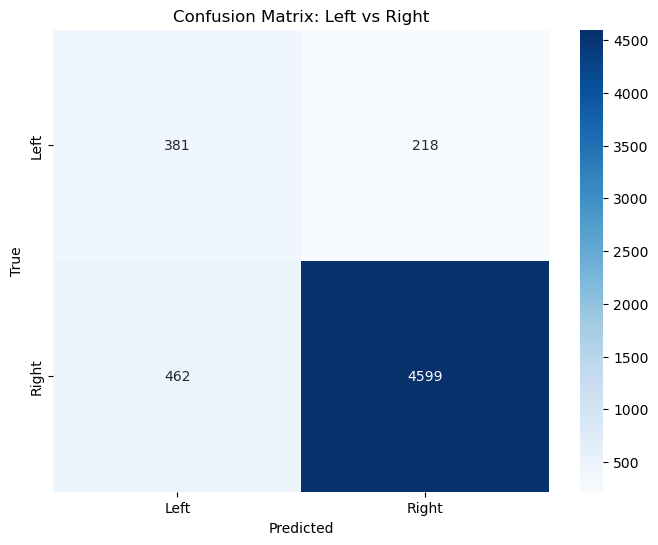

Classification Report: Left vs Right

              precision    recall  f1-score   support

        Left       0.45      0.64      0.53       599
       Right       0.95      0.91      0.93      5061

    accuracy                           0.88      5660
   macro avg       0.70      0.77      0.73      5660
weighted avg       0.90      0.88      0.89      5660



In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Random Forest for Left vs Right
# Train model
rf_lr = RandomForestClassifier(n_estimators=100, random_state=42)
rf_lr.fit(X_train_lr, y_train_lr)

# Predict
y_pred_lr = rf_lr.predict(X_test_lr)

# Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test_lr, y_pred_lr), annot=True, fmt='d', cmap='Blues',
            xticklabels=["Left", "Right"], yticklabels=["Left", "Right"])
plt.title("Confusion Matrix: Left vs Right")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Classification Report
print("Classification Report: Left vs Right\n")
print(classification_report(y_test_lr, y_pred_lr, target_names=["Left", "Right"]))

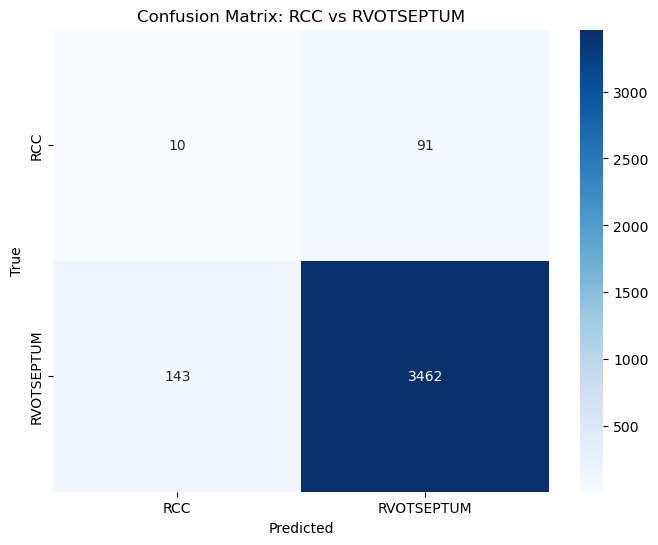

Classification Report: RCC vs RVOTSEPTUM

              precision    recall  f1-score   support

         RCC       0.07      0.10      0.08       101
  RVOTSEPTUM       0.97      0.96      0.97      3605

    accuracy                           0.94      3706
   macro avg       0.52      0.53      0.52      3706
weighted avg       0.95      0.94      0.94      3706



In [27]:
# Random Forest for RCC vs RVOTSEPTUM
# Train model
rf_rcc = RandomForestClassifier(n_estimators=100, random_state=42)
rf_rcc.fit(X_train_rcc, y_train_rcc_final)

# Predict
y_pred_rcc = rf_rcc.predict(X_test_rcc)

# Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test_rcc_final, y_pred_rcc), annot=True, fmt='d', cmap='Blues',
            xticklabels=["RCC", "RVOTSEPTUM"], yticklabels=["RCC", "RVOTSEPTUM"])
plt.title("Confusion Matrix: RCC vs RVOTSEPTUM")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Classification Report
print("Classification Report: RCC vs RVOTSEPTUM\n")
print(classification_report(y_test_rcc_final, y_pred_rcc, target_names=["RCC", "RVOTSEPTUM"]))

In [28]:
#!pip install xgboost

c:\Users\Usuario\anaconda3\envs\compbiomed\lib\site-packages\xgboost\core.py:158: UserWarning: [14:56:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


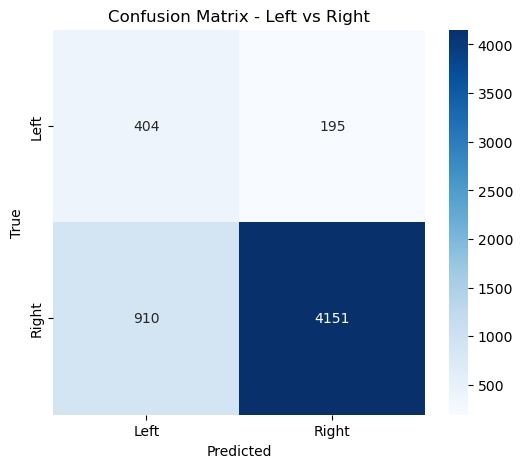


Classification Report: Left vs Right
              precision    recall  f1-score   support

        Left       0.31      0.67      0.42       599
       Right       0.96      0.82      0.88      5061

    accuracy                           0.80      5660
   macro avg       0.63      0.75      0.65      5660
weighted avg       0.89      0.80      0.83      5660



In [29]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

#  XGBoost for Left vs Right 
xgb_lr = XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_lr.fit(X_train_lr, y_train_lr)

y_pred_lr = xgb_lr.predict(X_test_lr)

# Evaluation
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test_lr, y_pred_lr), annot=True, fmt='d', cmap='Blues',
            xticklabels=["Left", "Right"], yticklabels=["Left", "Right"])
plt.title("Confusion Matrix - Left vs Right")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

print("\nClassification Report: Left vs Right")
print(classification_report(y_test_lr, y_pred_lr, target_names=["Left", "Right"]))

c:\Users\Usuario\anaconda3\envs\compbiomed\lib\site-packages\xgboost\core.py:158: UserWarning: [14:56:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


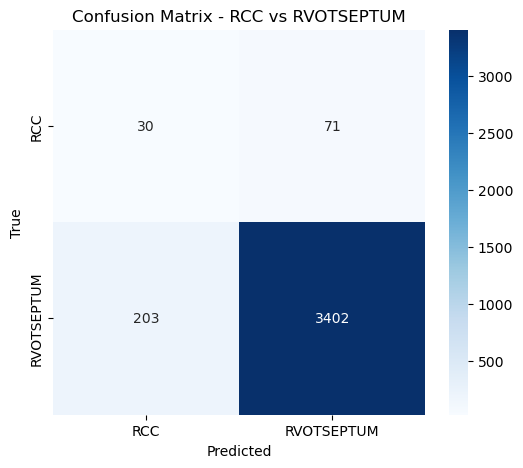


Classification Report: RCC vs RVOTSEPTUM
              precision    recall  f1-score   support

         RCC       0.13      0.30      0.18       101
  RVOTSEPTUM       0.98      0.94      0.96      3605

    accuracy                           0.93      3706
   macro avg       0.55      0.62      0.57      3706
weighted avg       0.96      0.93      0.94      3706



In [30]:
# XGBoost for RCC vs RVOTSEPTUM
xgb_rcc = XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_rcc.fit(X_train_rcc, y_train_rcc_final)

y_pred_rcc = xgb_rcc.predict(X_test_rcc)

# Evaluation
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test_rcc_final, y_pred_rcc), annot=True, fmt='d', cmap='Blues',
            xticklabels=["RCC", "RVOTSEPTUM"], yticklabels=["RCC", "RVOTSEPTUM"])
plt.title("Confusion Matrix - RCC vs RVOTSEPTUM")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

print("\nClassification Report: RCC vs RVOTSEPTUM")
print(classification_report(y_test_rcc_final, y_pred_rcc, target_names=["RCC", "RVOTSEPTUM"]))


Logistic Regression for Left vs Right
Best Params: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}


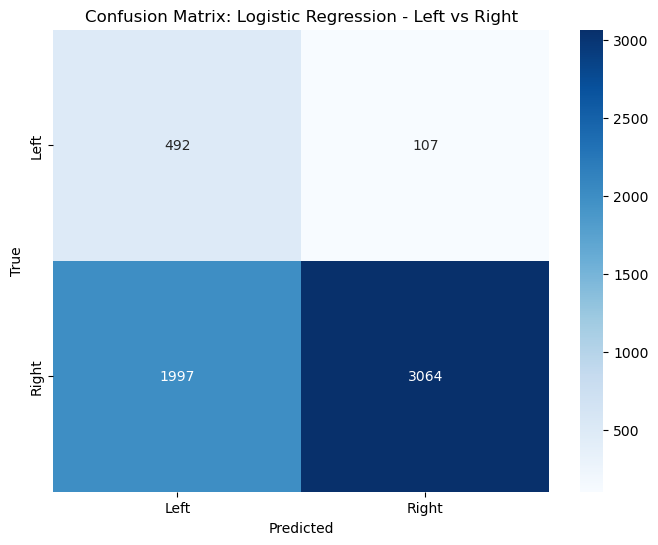

Classification Report: Logistic Regression - Left vs Right

              precision    recall  f1-score   support

        Left       0.20      0.82      0.32       599
       Right       0.97      0.61      0.74      5061

    accuracy                           0.63      5660
   macro avg       0.58      0.71      0.53      5660
weighted avg       0.88      0.63      0.70      5660


SVM (RBF) for Left vs Right
Best Params: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}


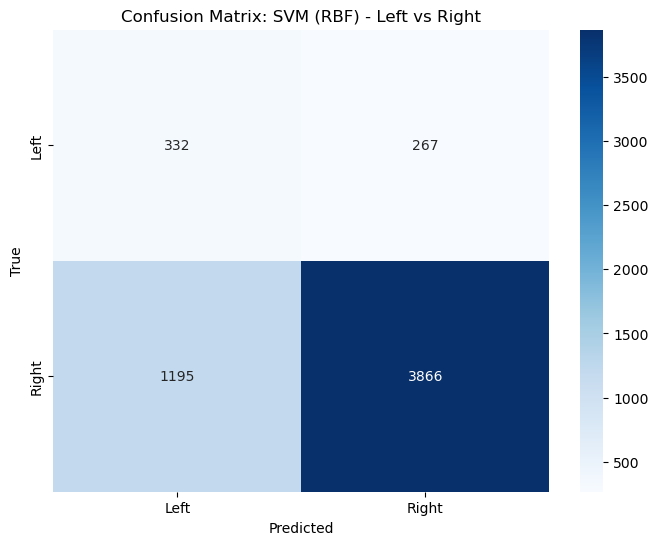

Classification Report: SVM (RBF) - Left vs Right

              precision    recall  f1-score   support

        Left       0.22      0.55      0.31       599
       Right       0.94      0.76      0.84      5061

    accuracy                           0.74      5660
   macro avg       0.58      0.66      0.58      5660
weighted avg       0.86      0.74      0.79      5660


k-NN for Left vs Right
Best Params: {'n_neighbors': 3, 'weights': 'distance'}


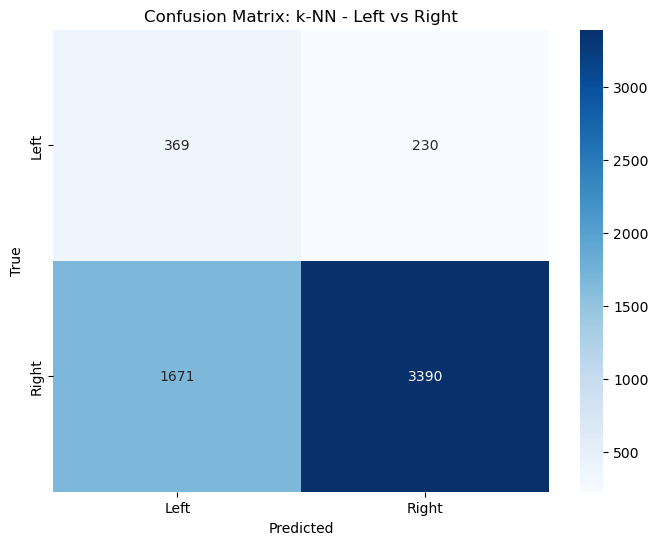

Classification Report: k-NN - Left vs Right

              precision    recall  f1-score   support

        Left       0.18      0.62      0.28       599
       Right       0.94      0.67      0.78      5061

    accuracy                           0.66      5660
   macro avg       0.56      0.64      0.53      5660
weighted avg       0.86      0.66      0.73      5660


Gradient Boosting for Left vs Right
Best Params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}


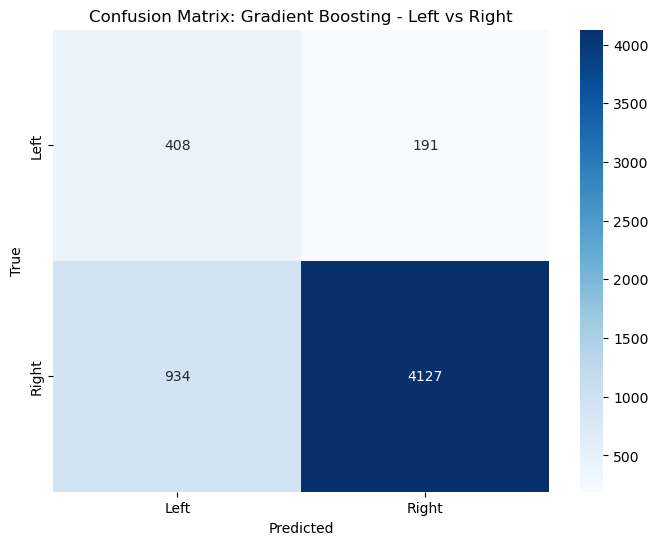

Classification Report: Gradient Boosting - Left vs Right

              precision    recall  f1-score   support

        Left       0.30      0.68      0.42       599
       Right       0.96      0.82      0.88      5061

    accuracy                           0.80      5660
   macro avg       0.63      0.75      0.65      5660
weighted avg       0.89      0.80      0.83      5660


MLP for Left vs Right
Best Params: {'activation': 'tanh', 'hidden_layer_sizes': (100, 50)}


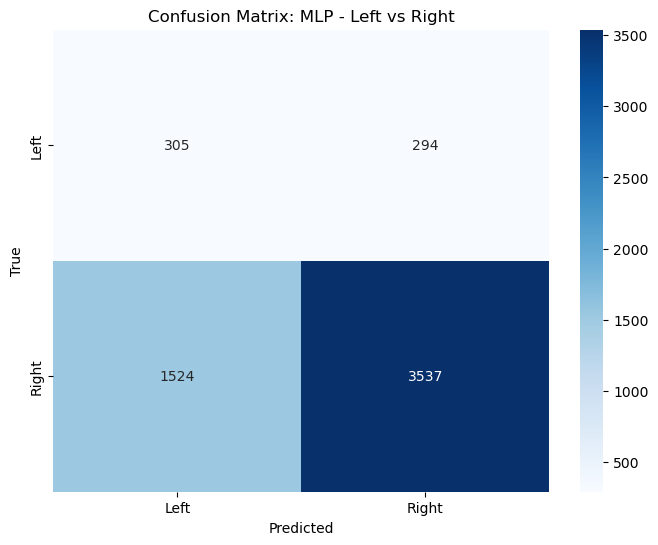

Classification Report: MLP - Left vs Right

              precision    recall  f1-score   support

        Left       0.17      0.51      0.25       599
       Right       0.92      0.70      0.80      5061

    accuracy                           0.68      5660
   macro avg       0.55      0.60      0.52      5660
weighted avg       0.84      0.68      0.74      5660


Logistic Regression for RCC vs RVOTSEPTUM
Best Params: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}


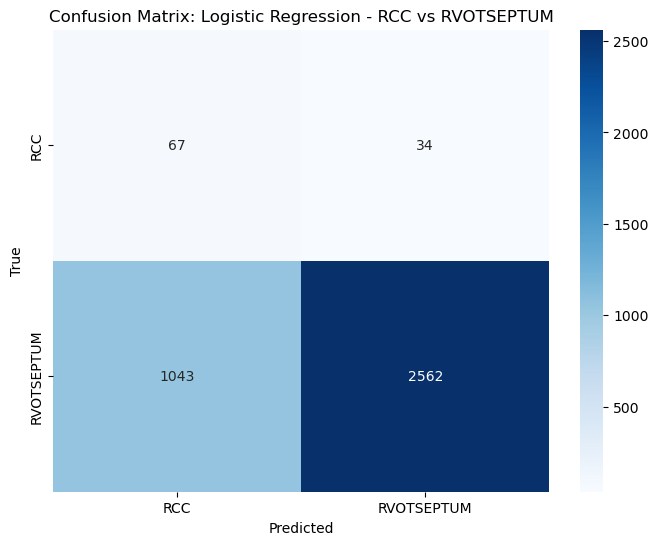

Classification Report: Logistic Regression - RCC vs RVOTSEPTUM

              precision    recall  f1-score   support

         RCC       0.06      0.66      0.11       101
  RVOTSEPTUM       0.99      0.71      0.83      3605

    accuracy                           0.71      3706
   macro avg       0.52      0.69      0.47      3706
weighted avg       0.96      0.71      0.81      3706


SVM (RBF) for RCC vs RVOTSEPTUM
Best Params: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}


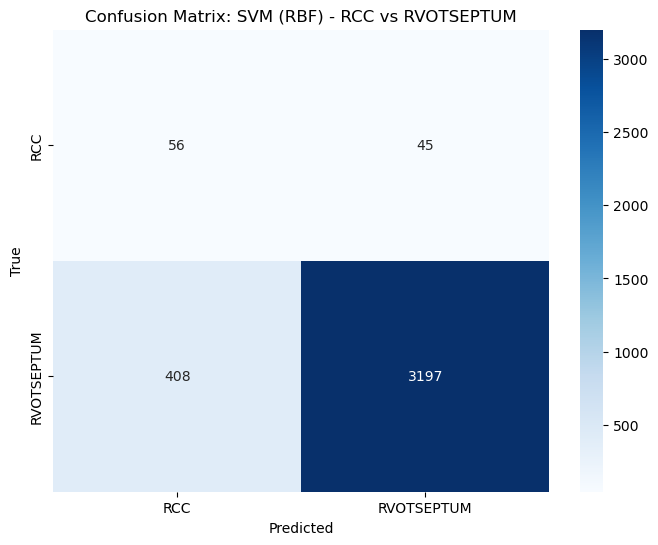

Classification Report: SVM (RBF) - RCC vs RVOTSEPTUM

              precision    recall  f1-score   support

         RCC       0.12      0.55      0.20       101
  RVOTSEPTUM       0.99      0.89      0.93      3605

    accuracy                           0.88      3706
   macro avg       0.55      0.72      0.57      3706
weighted avg       0.96      0.88      0.91      3706


k-NN for RCC vs RVOTSEPTUM
Best Params: {'n_neighbors': 3, 'weights': 'distance'}


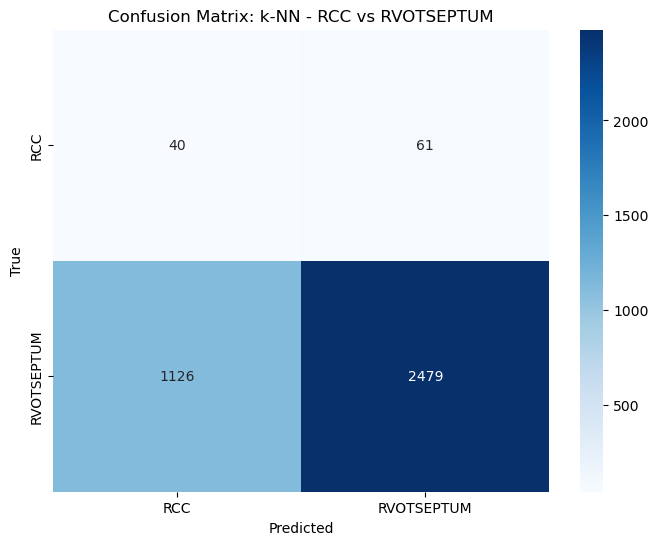

Classification Report: k-NN - RCC vs RVOTSEPTUM

              precision    recall  f1-score   support

         RCC       0.03      0.40      0.06       101
  RVOTSEPTUM       0.98      0.69      0.81      3605

    accuracy                           0.68      3706
   macro avg       0.51      0.54      0.43      3706
weighted avg       0.95      0.68      0.79      3706


Gradient Boosting for RCC vs RVOTSEPTUM
Best Params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}


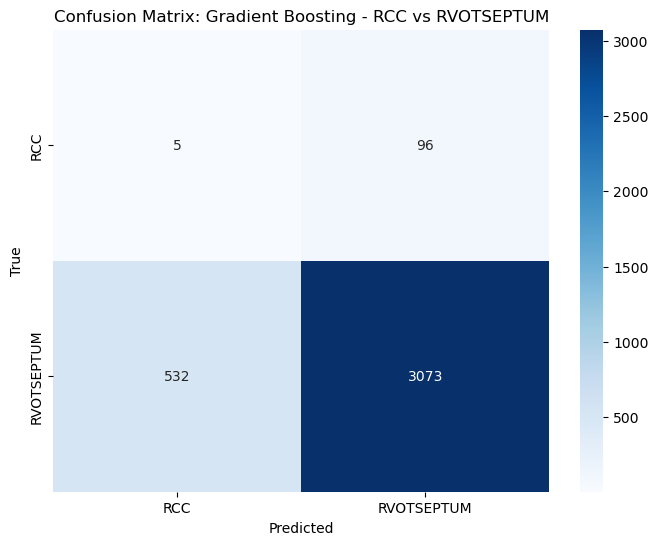

Classification Report: Gradient Boosting - RCC vs RVOTSEPTUM

              precision    recall  f1-score   support

         RCC       0.01      0.05      0.02       101
  RVOTSEPTUM       0.97      0.85      0.91      3605

    accuracy                           0.83      3706
   macro avg       0.49      0.45      0.46      3706
weighted avg       0.94      0.83      0.88      3706


MLP for RCC vs RVOTSEPTUM
Best Params: {'activation': 'relu', 'hidden_layer_sizes': (100,)}


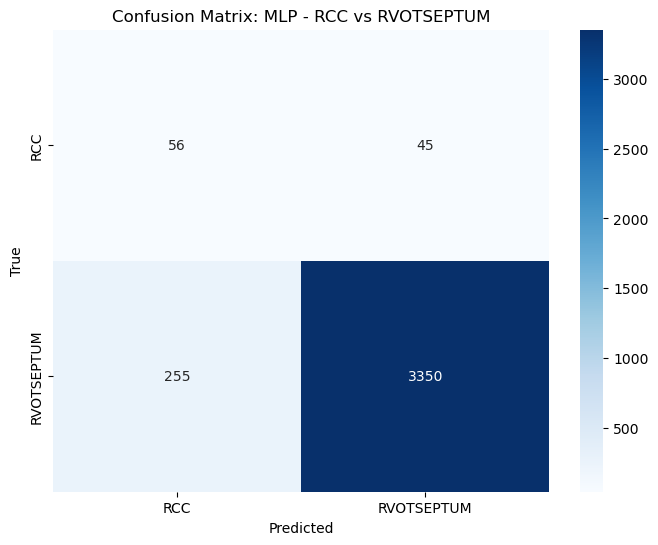

Classification Report: MLP - RCC vs RVOTSEPTUM

              precision    recall  f1-score   support

         RCC       0.18      0.55      0.27       101
  RVOTSEPTUM       0.99      0.93      0.96      3605

    accuracy                           0.92      3706
   macro avg       0.58      0.74      0.61      3706
weighted avg       0.96      0.92      0.94      3706



In [34]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define reusable function to train and evaluate multiple models with hyperparameter tuning
def train_and_evaluate_models_with_gridsearch(X_train, y_train, X_test, y_test, label_names, task_name=""):
    X_train = np.array(X_train)
    X_test = np.array(X_test)

    model_grid = {
        "Logistic Regression": (
            LogisticRegression(max_iter=1000, random_state=42),
            {"C": [0.01, 0.1, 1, 10], "penalty": ["l2"], "solver": ["lbfgs"]}
        ),
        "SVM (RBF)": (
            SVC(probability=True, random_state=42),
            {"C": [0.1, 1, 10], "gamma": ["scale", "auto"], "kernel": ["rbf"]}
        ),
        "k-NN": (
            KNeighborsClassifier(),
            {"n_neighbors": [3, 5, 7], "weights": ["uniform", "distance"]}
        ),
        "Gradient Boosting": (
            GradientBoostingClassifier(random_state=42),
            {"n_estimators": [50, 100], "learning_rate": [0.01, 0.1], "max_depth": [3, 5]}
        ),
        "MLP": (
            MLPClassifier(max_iter=500, random_state=42),
            {"hidden_layer_sizes": [(50,), (100,), (100, 50)], "activation": ["relu", "tanh"]}
        )
    }

    for name, (model, param_grid) in model_grid.items():
        print(f"\n{name} for {task_name}")
        grid = GridSearchCV(model, param_grid, cv=3, scoring="accuracy", n_jobs=-1)
        grid.fit(X_train, y_train)

        best_model = grid.best_estimator_
        print("Best Params:", grid.best_params_)

        y_pred = best_model.predict(X_test)

        # Confusion Matrix
        plt.figure(figsize=(8, 6))
        sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues',
                    xticklabels=label_names, yticklabels=label_names)
        plt.title(f"Confusion Matrix: {name} - {task_name}")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.show()

        # Classification Report
        print(f"Classification Report: {name} - {task_name}\n")
        print(classification_report(y_test, y_pred, target_names=label_names))


# ---- Use for Left vs Right ----
train_and_evaluate_models_with_gridsearch(
    X_train_lr, y_train_lr, X_test_lr, y_test_lr,
    label_names=["Left", "Right"],
    task_name="Left vs Right"
)

# ---- Use for RCC vs RVOTSEPTUM ----
train_and_evaluate_models_with_gridsearch(
    X_train_rcc, y_train_rcc_final, X_test_rcc, y_test_rcc_final,
    label_names=["RCC", "RVOTSEPTUM"],
    task_name="RCC vs RVOTSEPTUM"
)
